In [1]:
import requests
import zipfile
from pathlib import Path

## Import data

First we need to import the data from a repository. For small datasets, this can be located in the same place as the code, e.g. on GitHub. For larger datasets you need to store your data on a data repository like Zenodo or use your own server, like here for example from the Broad Institute:

In [2]:
if not Path('BBBC013_v1_images_bmp').is_dir():
    url = 'https://data.broadinstitute.org/bbbc/BBBC013/BBBC013_v1_images_bmp.zip'
    myfile = requests.get(url, allow_redirects=True)
    open('BBBC013_v1_images_bmp.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile('BBBC013_v1_images_bmp.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

## Import experimental information

In [3]:
import pandas as pd
import numpy as np

In [4]:
drugs = pd.read_csv('https://data.broadinstitute.org/bbbc/BBBC013/BBBC013_v1_platemap_all.txt')

In [5]:
len(drugs)

96

In [6]:
drug_amounts = pd.DataFrame(np.reshape(drugs.values, (8,12)))

In [7]:
drug_amounts

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
1,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
2,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
3,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
4,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
5,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
6,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
7,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0


In [8]:
import string

In [9]:
[string.ascii_uppercase[i] for i in range(12)]

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

In [10]:
drug_amounts.rename({i: i+1 for i in range(12)}, axis='columns', inplace=True)
drug_amounts.rename({i: string.ascii_uppercase[i] for i in range(12)}, axis='rows', inplace=True)

In [11]:
drug_amounts

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
B,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
C,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
D,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
E,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
F,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
G,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
H,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0


## Creating dataframe for conditions

In [12]:
drug_type = drug_amounts.copy()
drug_type[:] = 'Control'

drug_type.iloc[0:4,2:-1] = 'Wortmannin' 
drug_type.iloc[4:8,2:-1] = 'LY294002'
drug_type.iloc[0:4,0] = 'Negative Control'
drug_type.iloc[4:8,-1] = 'Negative Control'
drug_type.iloc[4:8,0] = 'Positive Control'
drug_type.iloc[0:4,-1] = 'Positive Control'
drug_type.iloc[:,1] = 'Empty'

In [13]:
drug_type

,1,2,3,4,5,6,7,8,9,10,11,12
A,Negative Control,Empty,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Positive Control
B,Negative Control,Empty,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Positive Control
C,Negative Control,Empty,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Positive Control
D,Negative Control,Empty,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Positive Control
E,Positive Control,Empty,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,Negative Control
F,Positive Control,Empty,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,Negative Control
G,Positive Control,Empty,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,Negative Control
H,Positive Control,Empty,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,Negative Control


## Merge dataframes

Now we merge the two informations and turn the dataframes into a long list where each line is one well and the location defined by a row and columns indices:

In [14]:
drug_info = pd.merge(drug_amounts.stack().reset_index(), drug_type.stack().reset_index(), on=('level_0', 'level_1'))
drug_info.rename({'level_0': 'well row', 'level_1': 'well column', '0_x': 'amount', '0_y': 'drug type'}, axis=1, inplace=True)
drug_info = drug_info.set_index(['well row', 'well column'])

In [15]:
drug_info

amount         drug type
well row well column                          
A        1              0.00  Negative Control
         2              0.00             Empty
         3              0.98        Wortmannin
         4              1.95        Wortmannin
         5              3.91        Wortmannin
...                      ...               ...
H        8             10.00          LY294002
         9             20.00          LY294002
         10            40.00          LY294002
         11            80.00          LY294002
         12             0.00  Negative Control

[96 rows x 2 columns]

## Parse files

In [16]:
data_path = Path('BBBC013_v1_images_bmp')

In [17]:
from natsort import natsorted

In [18]:
file_list1 = list(data_path.glob('Channel1*.BMP'))
file_list1 = natsorted(file_list1)

file_list2 = list(data_path.glob('Channel2*.BMP'))
file_list2 = natsorted(file_list2)

## Small pipeline

In [19]:
import skimage.io
import skimage.measure
import skimage.filters
import matplotlib.pyplot as plt

image1 = skimage.io.imread(file_list1[0])
image2 = skimage.io.imread(file_list2[0])

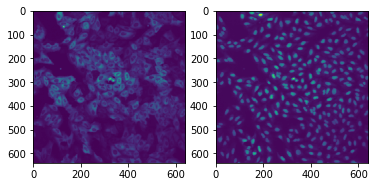

In [20]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image1)
ax[1].imshow(image2);

In [21]:
threshold = skimage.filters.threshold_otsu(image2)
mask = image2 > threshold

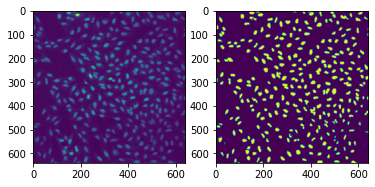

In [22]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image2)
ax[1].imshow(mask);

In [23]:
regions = skimage.measure.regionprops_table(skimage.measure.label(mask), intensity_image=image1,
                                           properties=('label','area','mean_intensity'))

In [24]:
regions['mean_intensity'].mean()

22.00778541620419

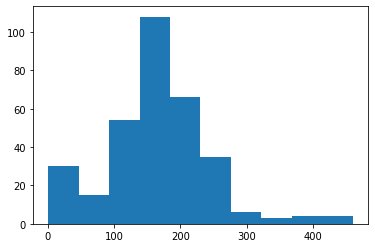

In [26]:
plt.hist(regions['area']);

We see that we have a small proportion of debris creating a "peak" at small areas. It is reasonable to set a size cutoff (as long as it's explicitly stated of course!). We can do this by indexing:

In [117]:
area_threshold = 50
selected_intensity = regions['mean_intensity'][regions['area'] > area_threshold]
selected_intensity.mean()

30.369579475227944

We need to parse the well-position of the image using regular expressions:

In [38]:
file_list1[0].name

'Channel1-01-A-01.BMP'

In [39]:
import re

In [40]:
position = re.findall('.*\-.*\-(.*)\-(.*)\.BMP',file_list1[0].name)

In [41]:
[position[0][0], int(position[0][1])]

['A', 1]

We create new columns to store information

In [42]:
drug_info['area'] = np.nan
drug_info['intensity'] = np.nan
drug_info['number nuclei'] = np.nan

We can add the information to our dataframe using the parsed location as indices:

In [43]:
drug_info.loc[(position[0][0], int(position[0][1])),'area'] = regions['area'][regions['area'] > area_threshold].mean()

In [44]:
drug_info

amount         drug type  ...  intensity  number nuclei
well row well column                            ...                          
A        1              0.00  Negative Control  ...        NaN            NaN
         2              0.00             Empty  ...        NaN            NaN
         3              0.98        Wortmannin  ...        NaN            NaN
         4              1.95        Wortmannin  ...        NaN            NaN
         5              3.91        Wortmannin  ...        NaN            NaN
...                      ...               ...  ...        ...            ...
H        8             10.00          LY294002  ...        NaN            NaN
         9             20.00          LY294002  ...        NaN            NaN
         10            40.00          LY294002  ...        NaN            NaN
         11            80.00          LY294002  ...        NaN            NaN
         12             0.00  Negative Control  ...        NaN            NaN

[96 rows x 5 columns]

Now we repeat the operation for each file in our folder. In addition to the mean values stored in ```drug_info``` we also keep the full intensity distributions as a list of DataFrames that we can concatenate at the end:

In [147]:
full_distributions= []
for f1, f2 in zip(file_list1, file_list2):
    
    image1 = skimage.io.imread(f1)
    image2 = skimage.io.imread(f2)

    threshold = skimage.filters.threshold_otsu(image2)
    mask = image2 > threshold
    
    regions = skimage.measure.regionprops_table(skimage.measure.label(mask), intensity_image=image1,
                                           properties=('label','area','mean_intensity'))
    
    position = re.findall('.*\-.*\-(.*)\-(.*)\.BMP',f1.name)
    
    drug_info.loc[(position[0][0], int(position[0][1])),'area'] = regions['area'][regions['area'] > area_threshold].mean()
    drug_info.loc[(position[0][0], int(position[0][1])),'intensity'] = regions['mean_intensity'][regions['area'] > area_threshold].mean()
    drug_info.loc[(position[0][0], int(position[0][1])),'number nuclei'] = len(regions['mean_intensity'][regions['area'] > area_threshold])

    # keep complete distributions
    distr = pd.DataFrame(regions).drop('label',axis='columns')
    distr = distr[distr.area > area_threshold]
    distr['amount'] = drug_info.loc[(position[0][0], int(position[0][1])),'amount']
    distr['drug type'] = drug_info.loc[(position[0][0], int(position[0][1])),'drug type']
    distr['well row'] = position[0][0]
    distr['well column'] = int(position[0][1])
    full_distributions.append(distr)

full_distributions = pd.concat(full_distributions)
full_distributions.rename({'mean_intensity': 'intensity'}, axis='columns', inplace=True)

In [146]:
drug_info

amount         drug type  ...  intensity  number nuclei
well row well column                            ...                          
A        1              0.00  Negative Control  ...  22.666447          295.0
         2              0.00             Empty  ...  26.706697          254.0
         3              0.98        Wortmannin  ...  32.932798          221.0
         4              1.95        Wortmannin  ...  39.716219          194.0
         5              3.91        Wortmannin  ...  43.372790          201.0
...                      ...               ...  ...        ...            ...
H        8             10.00          LY294002  ...  75.441240          148.0
         9             20.00          LY294002  ...  60.860972          191.0
         10            40.00          LY294002  ...  79.708546          118.0
         11            80.00          LY294002  ...  81.869397          193.0
         12             0.00  Negative Control  ...  30.369579          197.0

[96 rows x 5 columns]

## Plotting

In [119]:
import seaborn as sns

In [120]:
clean_drug = drug_info[drug_info['drug type'].isin(['LY294002','Wortmannin'])]

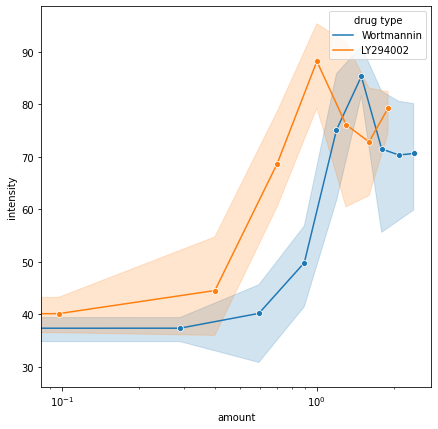

In [121]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sns.lineplot(data=clean_drug, x='amount', y='intensity', hue='drug type', ax=ax, marker="o");

In [122]:
from sklearn import linear_model

In [123]:
X = clean_drug.sort_values(by='amount')['amount'].values

X = X[:, np.newaxis]

y = clean_drug.sort_values(by='amount')['intensity'].values

In [124]:
ols = linear_model.LinearRegression()
ols.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

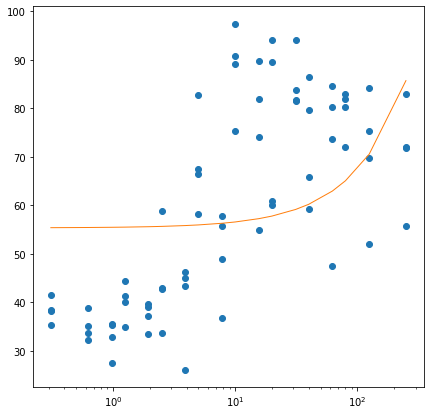

In [125]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(X,y,'o')
ax.plot(X, ols.coef_ * X + ols.intercept_, linewidth=1)
ax.set(xscale="log");


In [126]:
from scipy.optimize import curve_fit

def sigmoid (x, A, h, slope, C):
    return 1 / (1 + np.exp ((x - h) / slope)) *  A + C

p, _ = curve_fit(sigmoid, np.ravel(X), y)

In [127]:
x = np.ravel(X)

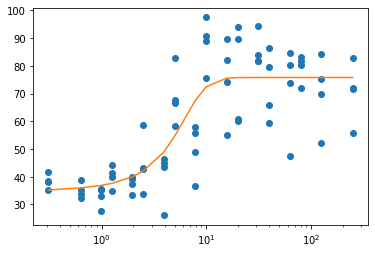

In [128]:
fig, ax = plt.subplots()
ax.set_xscale('log')
plt.plot(x, y, 'o')
plt.plot(x, sigmoid(x, *p));

In [129]:
clean_drug.reset_index()

,well row,well column,amount,drug type,area,intensity,number nuclei
0,A,3,0.98,Wortmannin,182.886878,32.932798,221.0
1,A,4,1.95,Wortmannin,177.804124,39.716219,194.0
2,A,5,3.91,Wortmannin,182.074627,43.372790,201.0
3,A,6,7.81,Wortmannin,186.004739,36.693686,211.0
4,A,7,15.63,Wortmannin,184.282723,54.870852,191.0
...,...,...,...,...,...,...,...
67,H,7,5.00,LY294002,175.466258,67.513106,163.0
68,H,8,10.00,LY294002,169.398649,75.441240,148.0
69,H,9,20.00,LY294002,173.026178,60.860972,191.0
70,H,10,40.00,LY294002,163.745763,79.708546,118.0


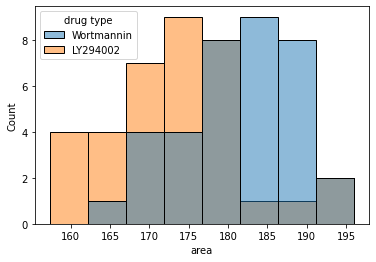

In [130]:
sns.histplot(data=clean_drug.reset_index(), x='area', hue='drug type');

In [149]:
clean_full = full_distributions.reset_index()

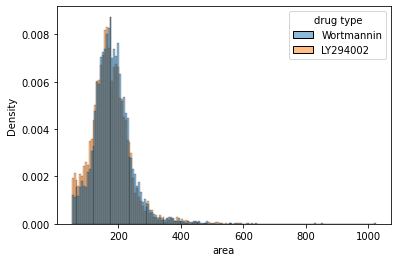

In [150]:
clean_fulll_drug = clean_full[clean_full['drug type'].isin(['LY294002','Wortmannin'])]

sns.histplot(data=clean_fulll_drug, x='area', hue='drug type', stat='density', common_norm=False);

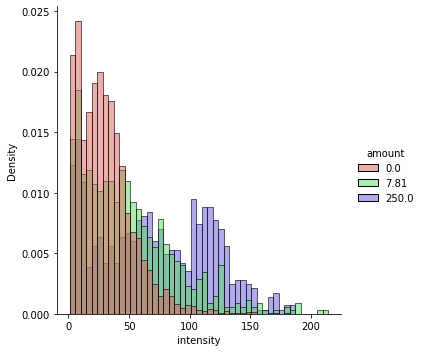

In [151]:
sns.displot(data=clean_full[(clean_full.amount==0) | (clean_full.amount==7.81) | (clean_full.amount==250)], x='intensity', hue='amount', stat='density', common_norm=False,
            palette=sns.color_palette("hls", 3));

## Export the data

In [ ]:
drug_info.reset_index().to_csv('BBBC013_analyzed.csv', index=False)

In [152]:
full_distributions.reset_index().to_csv('BBBC013_analyzed_full.csv', index=False)